# 0. Libraries


In [1]:
import keras
from keras import layers
import tensorflow as tf
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle as pkl
import itertools

2025-11-01 15:19:52.589141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762010392.776644      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762010392.825947      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ROOT_DATA = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr"

In [3]:
CLASSES = {
    'Araneae': 0,
    'Coleoptera': 1,
    'Diptera': 2,
    'Hemiptera': 3,
    'Hymenoptera': 4,
    'Lepidoptera': 5,
    'Odonata': 6
}
class_map = {v:k for k,v in CLASSES.items()}
C = len(CLASSES)

S = 7 # Grid parameter
B = 2 # Amount of boxes per cell

# Set the images width and height
IMG_WIDTH = 448
IMG_HEIGHT = 448

# 1. Functions

In [4]:
def get_all_json_files(root_dir):
    """This function get all json files in
    the root directory"""
    return list(Path(root_dir).rglob('annotations/*.json'))

In [5]:
def parse_annotation(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Get original image width and height
    img_w = data['asset']['size']['width']
    img_h = data['asset']['size']['height']

    # Get the regions
    regions = data['regions']

    # Create an zero tensors with the desired shape
    yolo_tensor = np.zeros((S, S, B*5 + C), dtype=np.float32)

    # Fill the tensor with the information from each region
    # We assume one region per cell
    for region in regions:
        bb = region['boundingBox']

        # Get x_center, y_center, width and height of the
        # Bbox and normalice with the image size
        w = bb['width'] / 2
        h = bb['height'] / 2
        x_center = (bb['left'] + w) / img_w
        y_center = (bb['top'] + h) / img_h

        # Normalize w and h with the whole image in rage [0, 1]
        w = bb['width'] / img_w
        h = bb['height'] / img_h

        # Get the cell with the center
        cell_x = int(x_center * S)
        cell_y = int(y_center * S)

        # Calculate the x and y centers relative to the cell
        x_rel = x_center * S - cell_x
        y_rel = y_center * S - cell_y

        # Get the class and its index
        class_name = region['tags'][0]
        class_idx = CLASSES[class_name]

        # Fill if tensor id empty
        if yolo_tensor[cell_y, cell_x, 4] == 0: #confidence, if there's an object is 1
            yolo_tensor[cell_y, cell_x, 0:5] = [x_rel, y_rel, w, h, 1]
            yolo_tensor[cell_y, cell_x, B*5 + class_idx] = 1 # One hot indicating the class
        else:
            # There're a previous object, skip the new one
            pass

    return yolo_tensor

In [6]:
def build_dataframe(json_files):
    data = []
    
    for jf in json_files:
        with open(jf, "r") as f:
            ann = json.load(f)

        # Get the image path
        img_path = ann['asset']['path']
        img_path = img_path.replace('file:F:/', "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/")

        # Get the class for stratify the datasets
        tag = img_path.split("/")[-2]
        tag_idx = CLASSES[tag]
        
        # If the image exists, add it to data; otherwise, throw an exception.
        if os.path.exists(img_path):
            data.append((img_path, str(jf), tag_idx))
        else:
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        # Create the pandas dataframe
        df = pd.DataFrame(data, columns=['img_path', 'json_path', 'tag'])
    
    return df

In [7]:
def parse_data_row(image_path, json_path):
    # Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = tf.cast(img, tf.float32) / 255.0

    # YOLO Tensor
    y_tensor = tf.numpy_function(
        func=parse_annotation,
        inp=[json_path],
        Tout=tf.float32
    )
    y_tensor.set_shape((S, S, B*5 + C))

    return img, y_tensor

In [8]:
def make_dataset(df, batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((
        df['img_path'].values,
        df['json_path'].values
    ))

    if shuffle:
        ds.shuffle(buffer_size=len(ds))

    # Load each image and their annotations
    ds = ds.map(parse_data_row, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds

In [9]:
def plot_image_with_boxes(img, yolo_tensor):
    fig, ax = plt.subplots(1, figsize=(6,6))

    # Plot the image
    ax.imshow(img)

    cell_size_x = IMG_WIDTH / S
    cell_size_y = IMG_HEIGHT / S

    for i in range (S):
        for j in range(S):
            if yolo_tensor[i, j, 4] != 0:
                x_rel, y_rel, w, h = yolo_tensor[i, j, 0:4]
                    
                # Get the center absoltute coordinates
                cx = (i + x_rel) * cell_size_x
                cy = (j + y_rel) * cell_size_y
                
                ax.plot(cx, cy, 'rx')
                
                # Get the box's width and height
                bw = w * IMG_WIDTH
                bh = h * IMG_HEIGHT

                # Draw the BBox
                x_rect = cx - bw / 2
                y_rect = cy - bh / 2
                rect = patches.Rectangle((x_rect, y_rect), bw, bh,
                                        linewidth=2, edgecolor='r', facecolor='none')
                
                ax.add_patch(rect)

                # Show the class
                conf = yolo_tensor[i, j, 4]
                label_probs = yolo_tensor[i, j, -C:]
                label = class_map[np.argmax(label_probs)]

                message = f"{label} | {100*conf:.2f}%"
                ax.text(x_rect+4, y_rect-5, message,
                       color='white',
                       backgroundcolor='red',
                       fontsize=8)
    
    plt.axis('off')
    plt.show()

In [10]:
def plot_training(history, num_std=3):
    keys = list(history.keys())
    plt.figure(figsize=(12,5))

    for i, k in enumerate(keys[:len(keys)//2]):
        train_data = history[k]
        val_key = 'val_' + k
        val_data = history[val_key] if val_key in history else []
        
        plt.subplot(1, 2, i+1)
        plt.plot(train_data, label='Train')
        if len(val_data) > 0:
            plt.plot(val_data, label='Validation')
        plt.title(k.title())

    plt.legend(loc='center', ncol=2, bbox_to_anchor=(-0.1, -0.125))
    plt.tight_layout()

# 2. Load data

Get all the json with the images information

In [11]:
annotations_json = get_all_json_files(ROOT_DATA)
print(f"There are {len(annotations_json)} annotations")

There are 15376 annotations


Generate a pandas df with the img path, json path and class

In [12]:
df = build_dataframe(annotations_json)
df.head()

,img_path,json_path,tag
0,/kaggle/input/arthropod-taxonomy-orders-object...,/kaggle/input/arthropod-taxonomy-orders-object...,1
1,/kaggle/input/arthropod-taxonomy-orders-object...,/kaggle/input/arthropod-taxonomy-orders-object...,1
2,/kaggle/input/arthropod-taxonomy-orders-object...,/kaggle/input/arthropod-taxonomy-orders-object...,1
3,/kaggle/input/arthropod-taxonomy-orders-object...,/kaggle/input/arthropod-taxonomy-orders-object...,1
4,/kaggle/input/arthropod-taxonomy-orders-object...,/kaggle/input/arthropod-taxonomy-orders-object...,1


Let's visualize how many images we have of each class

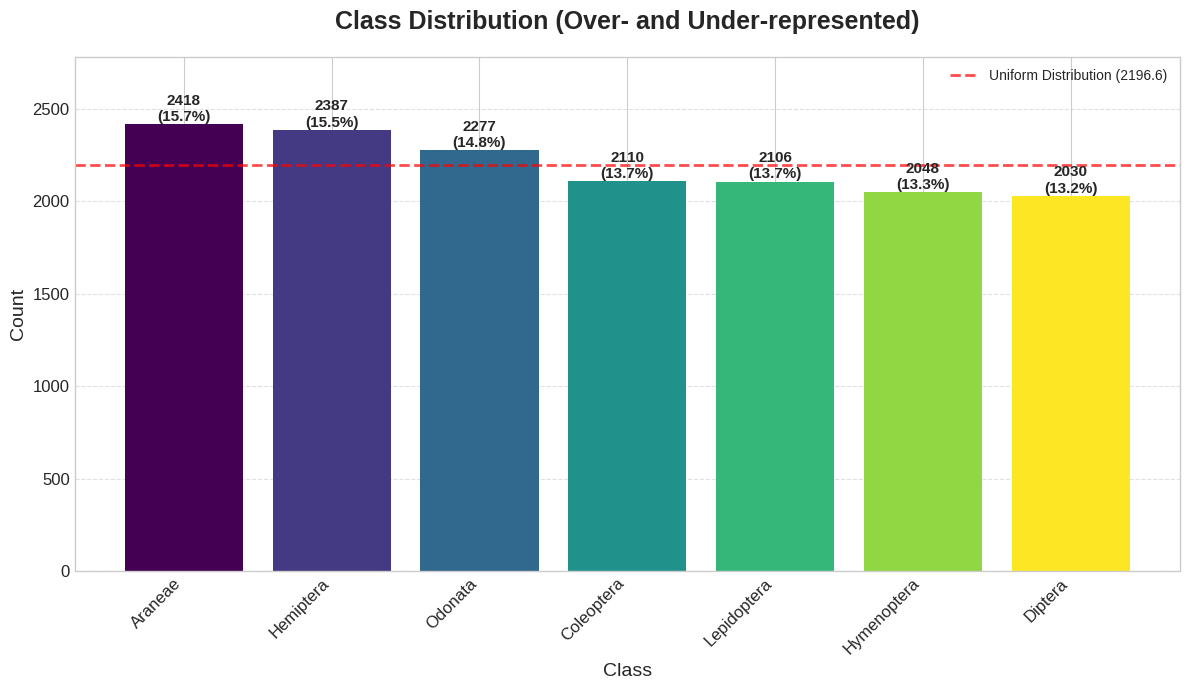

In [13]:
count = df['tag'].map(class_map).value_counts()
total_sum = count.sum()
uniform_value = total_sum / C

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(count)))
bars = ax.bar(count.index, count.values, color=colors)

ax.set_title('Class Distribution (Over- and Under-represented)', fontsize=18, pad=20, weight='bold')
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

for bar in bars:
    height = bar.get_height()
    relative_value = (height / total_sum) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
            f'{int(height)}\n({relative_value:.1f}%)',
            ha='center', va='bottom', fontsize=11, weight='bold')

max_count = count.max()
ax.set_ylim(0, max_count * 1.15)

ax.axhline(uniform_value, color='red', alpha=0.7, linestyle='--', linewidth=2, label=f'Uniform Distribution ({uniform_value:.1f})')
ax.legend()

ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.show()

Let's split in train, test and validation using stratification to preserve the class distribution.

In [14]:
train_df, test_df = train_test_split(
    df, test_size=0.25, stratify=df["tag"], random_state=42
)
test_df, val_df = train_test_split(
    test_df, test_size=0.5, stratify=test_df["tag"], random_state=42
)

In [15]:
print(f"Total\t{df.shape[0]}\t(100%)")
print("-"*25)
print(f"Train\t{train_df.shape[0]}\t({(100*train_df.shape[0]/df.shape[0]):.2f}%)")
print(f"Test\t{test_df.shape[0]}\t({(100*test_df.shape[0]/df.shape[0]):.2f}%)")
print(f"Val\t{val_df.shape[0]}\t({(100*val_df.shape[0]/df.shape[0]):.2f}%)")

Total	15376	(100%)
-------------------------
Train	11532	(75.00%)
Test	1922	(12.50%)
Val	1922	(12.50%)


Let's create these three datasets

In [16]:
train_ds = make_dataset(train_df)
val_ds   = make_dataset(val_df, shuffle=False)
test_ds  = make_dataset(test_df, shuffle=False)

I0000 00:00:1762010507.312004      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
for images, labels in train_ds.take(1):
    print("Imágenes:", images.shape, images.dtype)
    print("Labels:", labels.shape, labels.dtype)

Imágenes: (16, 448, 448, 3) <dtype: 'float32'>
Labels: (16, 7, 7, 17) <dtype: 'float32'>


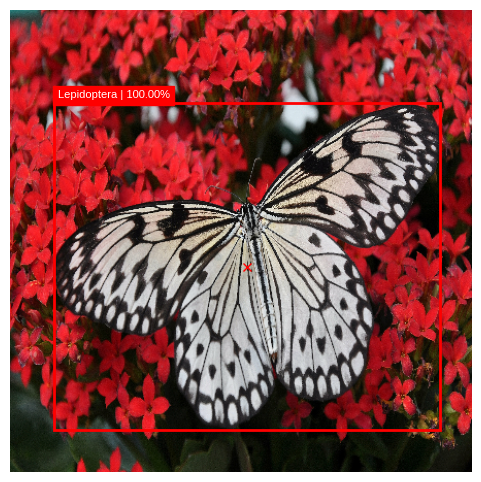

In [18]:
img, y = next(iter(train_ds.unbatch()))
plot_image_with_boxes(img, y)

# 3. Define Model

In [19]:
def yolo_head(x):
    """This funtion applies the adecuate activation functions"""
    box_xy      = tf.sigmoid(x[..., 0:2])          # x, y
    box_wh      = x[..., 2:4]                      # w, h lineales
    box_conf    = tf.sigmoid(x[..., 4:5])          # confidence
    class_probs = tf.nn.softmax(x[..., 5:], axis=-1) # clases
    return tf.concat([box_xy, box_wh, box_conf, class_probs], axis=-1)

In [20]:
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Convolutional Block
x = layers.Conv2D(64, (7,7), strides=2, padding='same', activation='leaky_relu') (inputs)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(192, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(128, (1,1), activation='leaky_relu') (x)
x = layers.Conv2D(256, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.Conv2D(256, (1,1), activation='leaky_relu') (x)
x = layers.Conv2D(512, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

for _ in range(4):
    x = layers.Conv2D(256, (1,1), activation='leaky_relu') (x)
    x = layers.Conv2D(512, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.Conv2D(512, (1,1), padding='same', activation='leaky_relu') (x)
x = layers.Conv2D(1024, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

for _ in range(2):
    x = layers.Conv2D(512, (1,1), activation='leaky_relu') (x)
    x = layers.Conv2D(1024, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.Conv2D(1024, (3,3), padding='same', activation='leaky_relu') (x)
x = layers.Conv2D(1024, (3,3), strides=2, padding='same', activation='leaky_relu') (x)

for _ in range(2):
    x = layers.Conv2D(1024, (3,3), padding='same', activation='leaky_relu') (x)

# Fully Conected
x = layers.Flatten() (x)
x = layers.Dense(500, activation='leaky_relu') (x) # Reducted from original paper 4096 for save in time
x  = layers.Dropout(0.5) (x)

# Output layer
outputs = layers.Dense(S*S*(5*B+C), activation='linear')(x)
outputs = layers.Reshape((S, S, 5*B + C)) (outputs)
outputs = layers.Lambda(yolo_head)(outputs)

# Compute the model
model = keras.models.Model(inputs, outputs, name='YOLOv1')

In [21]:
model.summary()

Model: "YOLOv1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 192)  │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 512)    │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 1024)   │     4,719,61

 Total params: 85,661,801 (326.77 MB)

 Trainable params: 85,661,801 (326.77 MB)

 Non-trainable params: 0 (0.00 B)

Let's create the loss function based on YoloV1 Paper

In [22]:
def yolo_v1_loss(lambda_coord=5.0, lambda_noobj=0.5):

    def loss_fn(y_true, y_pred):
        # Format (S, S, B*5 + C)

        # Split predicted boxes and classes
        pred_boxes = tf.reshape(y_pred[..., :B*5], (-1, S, S, B, 5))
        pred_classes = y_pred[..., B*5:]

        # Split true boxes and classes
        true_boxes = tf.reshape(y_true[..., :B*5], (-1, S, S, B, 5))
        true_classes = y_true[..., B*5:]

        # Store each value in a variable
        x_pred, y_pred, w_pred, h_pred, conf_pred = tf.split(pred_boxes, 5, axis=-1)
        x_true, y_true, w_true, h_true, conf_true = tf.split(true_boxes, 5, axis=-1)

        # Get the mask. 1 if there's object, otherwhise 0
        obj_mask = conf_true
        noobj_mask = 1 - conf_true

        ######## Loss calculation ########
        # TERM 1: Error in x, y
        xy_loss = tf.reduce_sum(
            obj_mask * (tf.square(x_pred - x_true) + tf.square(y_pred - y_true))
        )

        # TERM 2: Error in w,h
        sqrt_w_pred = tf.sqrt(tf.maximum(w_pred, 1e-9)) # If the value is too small, we use 1e-9 instead
        sqrt_h_pred = tf.sqrt(tf.maximum(h_pred, 1e-9))
        sqrt_w_true = tf.sqrt(tf.maximum(w_true, 1e-9))
        sqrt_h_true = tf.sqrt(tf.maximum(h_true, 1e-9))

        wh_loss =  tf.reduce_sum(
            obj_mask * (tf.square(sqrt_w_pred - sqrt_w_true) + tf.square(sqrt_h_pred - sqrt_h_true))
        )

        # TERM 3: Confidence when there is an object
        conf_obj_loss = tf.reduce_sum(obj_mask * tf.square(conf_pred - conf_true))

        # TERM 4: Confidence when there is no an object
        conf_noobj_loss = tf.reduce_sum(noobj_mask * tf.square(conf_pred - conf_true))

        # TERM 5: Classification
        class_loss = tf.reduce_sum(
            obj_mask[..., 0] * tf.reduce_sum(tf.square(pred_classes - true_classes))
        )

        # COMBINE
        total_loss = (
            lambda_coord * xy_loss +
            lambda_coord * wh_loss + 
            conf_obj_loss +
            lambda_noobj * conf_noobj_loss +
            class_loss
        )

        # Normalice the loss per batch
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        return total_loss / (batch_size + 1e-9)

    return loss_fn

In [23]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    loss=yolo_v1_loss(),
    metrics=[]
)

In [24]:
model_path = '/kaggle/working/yolov1_model.h5'

callbacks = [
    # Save the best model
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),

    # Stop training
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce LR
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# 4. Train Model

In [25]:
hist_path = '/kaggle/working/history_yolo_v1.pkl'

# Load if exists
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path, custom_objects={"loss_fn": yolo_v1_loss}) # Compile=False due the personalized loss function

    with open(hist_path, 'rb') as f:
        history_yolo_v1 = pkl.load(f)
    
else:
    # Trainig if the model doesn't exists
    history_yolo_v1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10, # TODO
        callbacks=callbacks
    )

    with open(hist_path, 'wb') as f:
        pkl.dump(history_yolo_v1.history, f)
        history_yolo_v1 = history_yolo_v1.history

Epoch 1/10


I0000 00:00:1762010520.667741      99 service.cc:148] XLA service 0x7fad00007ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762010520.668731      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762010521.848625      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/721 ━━━━━━━━━━━━━━━━━━━━ 5:52:38 29s/step - loss: 80.6762

I0000 00:00:1762010539.588628      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 37.0468
Epoch 1: val_loss improved from inf to 27.11413, saving model to /kaggle/working/yolov1_model.h5
721/721 ━━━━━━━━━━━━━━━━━━━━ 227s 274ms/step - loss: 37.0373 - val_loss: 27.1141 - learning_rate: 1.0000e-04
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 28.3758
Epoch 2: val_loss improved from 27.11413 to 26.81035, saving model to /kaggle/working/yolov1_model.h5
721/721 ━━━━━━━━━━━━━━━━━━━━ 166s 229ms/step - loss: 28.3740 - val_loss: 26.8104 - learning_rate: 1.0000e-04
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 67.3323
Epoch 3: val_loss did not improve from 26.81035
721/721 ━━━━━━━━━━━━━━━━━━━━ 160s 221ms/step - loss: 67.3250 - val_loss: 32.0137 - learning_rate: 1.0000e-04
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 29.5817
Epoch 4: val_loss improved from 26.81035 to 26.75495, saving model to /kaggle/working/yolov1_model.h5
721/721 ━━━━━━━━━━━━━━━━━━━━ 160s 221ms/step - loss: 29

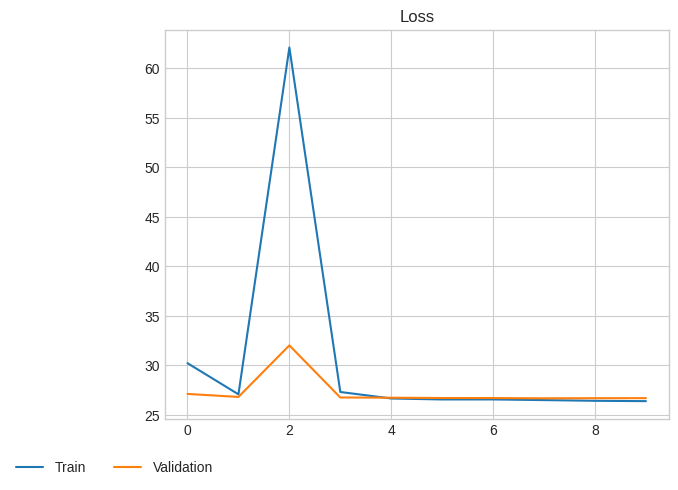

In [29]:
plot_training(history_yolo_v1)

# 5. Inference and metrics

We are going to perform an inference of the model with a set of images from test_ds.

In [30]:
# Get 9 images from test_ds
n_samples = 9
img_sample, y_true_sample = zip(*list(itertools.islice(test_ds.unbatch().as_numpy_iterator(), n_samples)))
img_sample, y_true_sample = np.stack(img_sample), np.stack(y_true_sample)

print(f"Number of images: {len(img_sample)}")
print(f"Shape of one image: {img_sample[0].shape}")
print(f"Shape of one label: {y_true_sample[0].shape}")

Number of images: 9
Shape of one image: (448, 448, 3)
Shape of one label: (7, 7, 17)


Let's run the images through the model to get its prediction.

In [31]:
y_pred_sample = model.predict(img_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Let's take a look to the tesor shape, it must be (batch, S, S, 5*B + C)

In [32]:
y_pred_sample.shape

(9, 7, 7, 17)

We present the predicted bounding boxes on the left and the corresponding ground‑truth bounding boxes on the right.

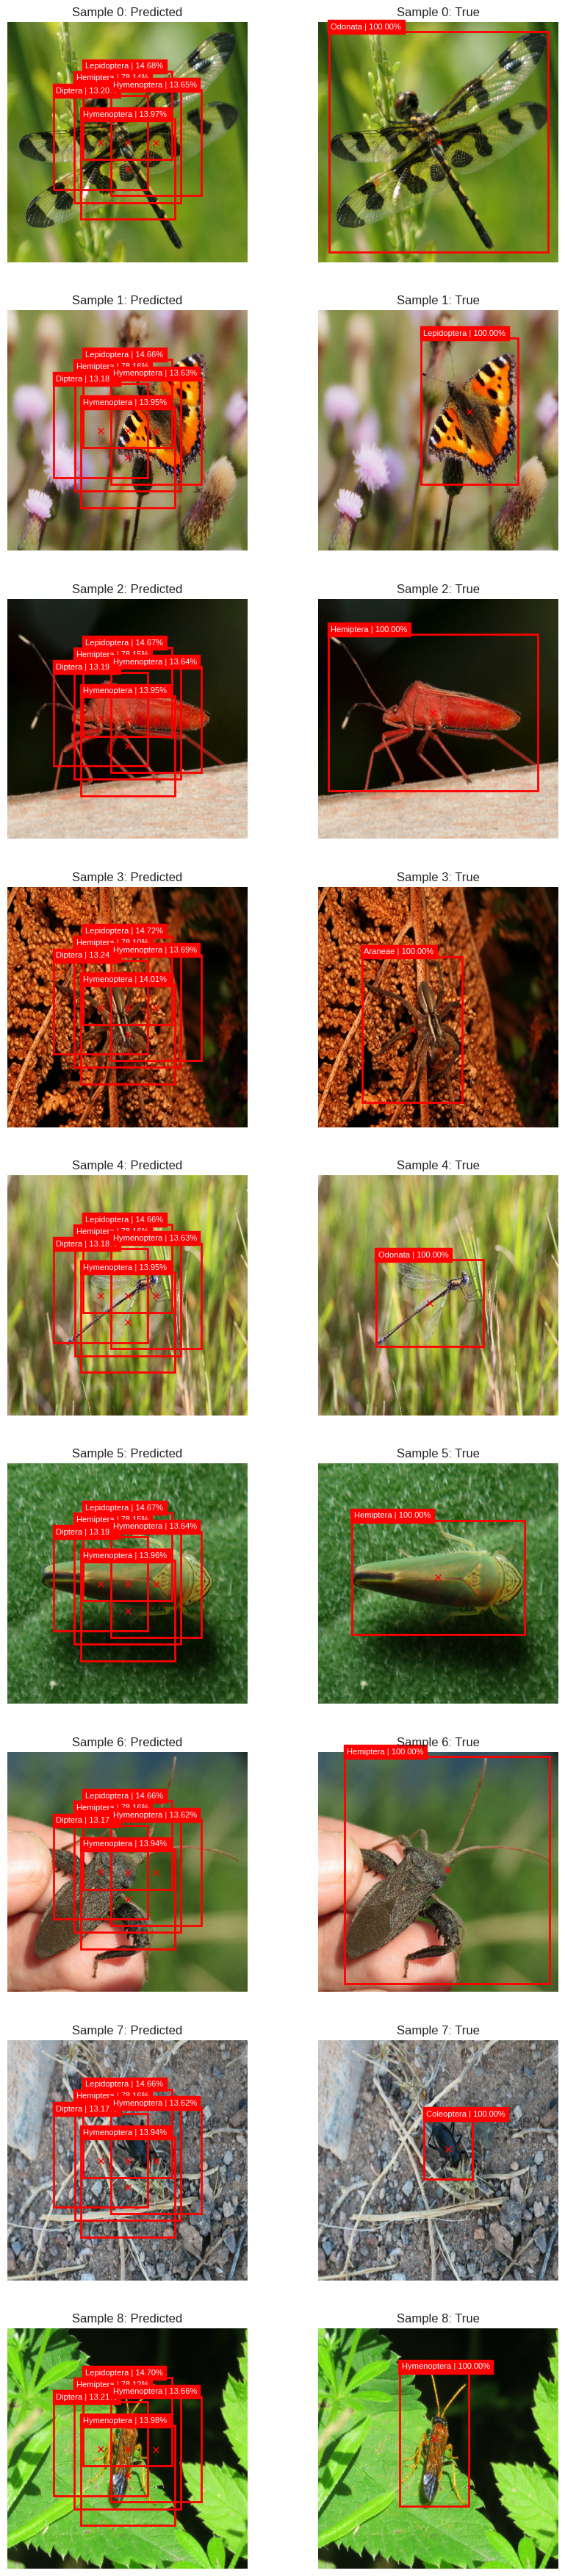

In [33]:
def add_annotations(ax, yolo_tensor, min_conf=0.0):
    
    cell_size_x = IMG_WIDTH / S
    cell_size_y = IMG_HEIGHT / S

    for i in range (S):
        for j in range (S):
            if yolo_tensor[i, j, 4] >= min_conf: # at least min_conf [0, 1] for plot.

                # Extract the values
                x_rel, y_rel, w, h = yolo_tensor[i, j, 0:4]
                
                # Get the center absoltute coordinates
                cx = (j + x_rel) * cell_size_x
                cy = (i + y_rel) * cell_size_y
                
                ax.plot(cx, cy, 'rx')
                
                # Get the box's width and height
                bw = w * IMG_WIDTH
                bh = h * IMG_HEIGHT

                # Draw the BBox
                x_rect = cx - bw / 2
                y_rect = cy - bh / 2
                rect = patches.Rectangle((x_rect, y_rect), bw, bh,
                                        linewidth=2, edgecolor='r', facecolor='none')
                
                ax.add_patch(rect)

                # Show the class
                conf = yolo_tensor[i, j, 4]
                label_probs = yolo_tensor[i, j, -C:]
                label = class_map[np.argmax(label_probs)]

                message = f"{label} | {100*conf:.2f}%"
                ax.text(x_rect+4, y_rect-5, message,
                       color='white',
                       backgroundcolor='red',
                       fontsize=8)

    return ax
    
def plot_predictions_vs_groundtruth(img_sample, y_true_sample, y_pred_sample):
    
    n_img = img_sample.shape[0]
    fig, axs = plt.subplots(n_img, 2, figsize=(10, 5*n_img))
          
    for i in range(n_img):
        for j in range(2):
            axs[i, j].imshow(img_sample[i])
            axs[i, j].axis("off")

            # Switch between predictions and true
            if j == 0: #Prediction
                add_annotations(axs[i,j], y_pred_sample[i], 0.1) # 10% or bigger confidence to plot
                title = f"Sample {i}: Predicted"
            else: # Ground truth
                add_annotations(axs[i,j], y_true_sample[i], 1) # Confidence 100% in all, it's the true value
                title = f"Sample {i}: True"

            axs[i, j].set_title(title)

    #plt.tight_layout()
    plt.show()   

plot_predictions_vs_groundtruth(img_sample, y_true_sample, y_pred_sample)